In [1]:
import os
import time
import random
import sys  
import matplotlib.pyplot as plt
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report

In [2]:
ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "../"))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)
print(ROOT_DIR)

from src.utils.pil import base64_to_pil

/root/upstageailab-cv-classification-cv_7


# MissClassification 분석


In [9]:
data_path = "./../../data/misclassification_triplet.csv"
df = pd.read_csv(data_path)

df.head(10)

img_name  pred  label  \
0  186099f62d5cb389.jpg    10     10   
1  457cd32cb351d570.jpg    12     12   
2  591f6b87942dfe1d.jpg     7      7   
3  898368eb7ad07511.jpg     2      2   
4  d54f10f7792df3ec.jpg     7      7   
5  ab550f9eba0bb66e.jpg    11     11   
6  055b74c6c5f5d86b.jpg    14     14   
7  e55e2da78637ab9a.jpg    15     15   
8  513df60c6920cc57.jpg     2      2   
9  d701754e411dcacb.jpg    10     10   

                                                 img  
0  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
1  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
2  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
3  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
4  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
5  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
6  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
7  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
8  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
9  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...

In [4]:
# classification_report 로 f1 score 계산
report = classification_report(df['label'], df['pred'], output_dict=True)
report_df = pd.DataFrame(report).transpose().reset_index()
report_df = report_df.rename(columns={"index": "class"})

# 정수 클래스만 필터링 (macro avg, weighted avg 제외)
report_df = report_df[report_df['class'].str.isdigit()]
report_df['class'] = report_df['class'].astype(int)

report_df = report_df.sort_values(by='class').reset_index(drop=True)

In [8]:
data_path = "./../../data/misclassification_normal.csv"
df_normal = pd.read_csv(data_path)

display(df_normal.head(10))

report_normal = classification_report(df_normal['label'], df_normal['pred'], output_dict=True)
report_df_normal = pd.DataFrame(report_normal).transpose().reset_index()
report_df_normal = report_df_normal.rename(columns={"index": "class"})

# 정수 클래스만 필터링 (macro avg, weighted avg 제외)
report_df_normal = report_df_normal[report_df_normal['class'].str.isdigit()]
report_df_normal['class'] = report_df_normal['class'].astype(int)

report_df_normal = report_df_normal.sort_values(by='class').reset_index(drop=True)

display(report_df_normal)

img_name  pred  label  \
0  186099f62d5cb389.jpg    10     10   
1  457cd32cb351d570.jpg    12     12   
2  591f6b87942dfe1d.jpg     7      7   
3  898368eb7ad07511.jpg     2      2   
4  d54f10f7792df3ec.jpg     7      7   
5  ab550f9eba0bb66e.jpg    11     11   
6  055b74c6c5f5d86b.jpg    14     14   
7  e55e2da78637ab9a.jpg    15     15   
8  513df60c6920cc57.jpg     2      2   
9  d701754e411dcacb.jpg    10     10   

                                                 img  
0  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
1  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
2  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
3  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
4  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
5  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
6  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
7  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
8  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
9  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...

class  precision    recall  f1-score  support
0       0   1.000000  1.000000  1.000000    160.0
1       1   1.000000  0.986486  0.993197     74.0
2       2   1.000000  1.000000  1.000000    160.0
3       3   0.861446  0.893750  0.877301    160.0
4       4   0.993243  0.918750  0.954545    160.0
5       5   1.000000  0.993750  0.996865    160.0
6       6   0.981481  0.993750  0.987578    160.0
7       7   0.818681  0.931250  0.871345    160.0
8       8   1.000000  1.000000  1.000000    160.0
9       9   0.993789  1.000000  0.996885    160.0
10     10   1.000000  0.975000  0.987342    160.0
11     11   0.987654  1.000000  0.993789    160.0
12     12   0.987578  0.993750  0.990654    160.0
13     13   1.000000  0.983051  0.991453    118.0
14     14   0.970149  0.812500  0.884354     80.0
15     15   1.000000  0.993750  0.996865    160.0
16     16   1.000000  1.000000  1.000000    160.0

In [5]:
display(report_df)

class  precision   recall  f1-score  support
0       0   0.993789  1.00000  0.996885    160.0
1       1   1.000000  1.00000  1.000000     74.0
2       2   1.000000  0.99375  0.996865    160.0
3       3   0.967742  0.93750  0.952381    160.0
4       4   0.975309  0.98750  0.981366    160.0
5       5   1.000000  1.00000  1.000000    160.0
6       6   0.993789  1.00000  0.996885    160.0
7       7   0.928571  0.97500  0.951220    160.0
8       8   1.000000  1.00000  1.000000    160.0
9       9   1.000000  1.00000  1.000000    160.0
10     10   0.987654  1.00000  0.993789    160.0
11     11   1.000000  0.99375  0.996865    160.0
12     12   1.000000  0.99375  0.996865    160.0
13     13   1.000000  1.00000  1.000000    118.0
14     14   1.000000  0.92500  0.961039     80.0
15     15   1.000000  1.00000  1.000000    160.0
16     16   1.000000  1.00000  1.000000    160.0

In [ ]:
data_path = "./../../data/misclassification_triplet1_25.csv"
df1_25 = pd.read_csv(data_path)

display(df1_25.head(10))

report1_25 = classification_report(df1_25['label'], df1_25['pred'], output_dict=True)
report_df1_25 = pd.DataFrame(report1_25).transpose().reset_index()
report_df1_25 = report_df1_25.rename(columns={"index": "class"})

# 정수 클래스만 필터링 (macro avg, weighted avg 제외)
report_df1_25 = report_df1_25[report_df1_25['class'].str.isdigit()]
report_df1_25['class'] = report_df1_25['class'].astype(int)

report_df1_25 = report_df1_25.sort_values(by='class').reset_index(drop=True)

display(report_df1_25)

In [4]:
mapping_df = pd.read_csv("./../../data/meta.csv")

## 틀린 이미지 분석

In [5]:
df_miss = df[df["pred"] != df["label"]]

# 데이터 분포 확인
display(df_miss["label"].value_counts())

# 데이터 분포 확인
display(df_miss["pred"].value_counts())

# 데이터 분포 확인
display(df_miss["fold"].value_counts())

# 데이터 분포 확인

label
7     86
3     75
14    32
4     29
10    15
11    10
13     8
12     4
1      3
8      1
6      1
Name: count, dtype: int64

pred
3     93
7     85
4     24
14    22
11     9
10     7
13     7
12     6
1      5
15     3
0      2
6      1
Name: count, dtype: int64

fold
4    64
0    60
3    49
1    47
2    44
Name: count, dtype: int64

In [ ]:
def show_images_with_preds(base64_list, preds, labels, n_cols=4):
    n_imgs = len(base64_list)
    n_rows = (n_imgs + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    for i, base64_str in enumerate(base64_list):
        img = base64_to_pil(base64_str)

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        pred = preds[i]
        label = labels[i]
        title = f"Pred: {pred} | Label: {label}"
        color = "green" if pred == label else "red"
        plt.title(title, color=color)

    plt.tight_layout()
    plt.show()

### label = 3(confirmation_of_admission_and_discharge) 분석

In [7]:
df_miss3 = df_miss[df_miss['label'] == 3]

df_miss3['pred'].value_counts()

pred
7     56
4      9
14     6
1      1
12     1
11     1
10     1
Name: count, dtype: int64

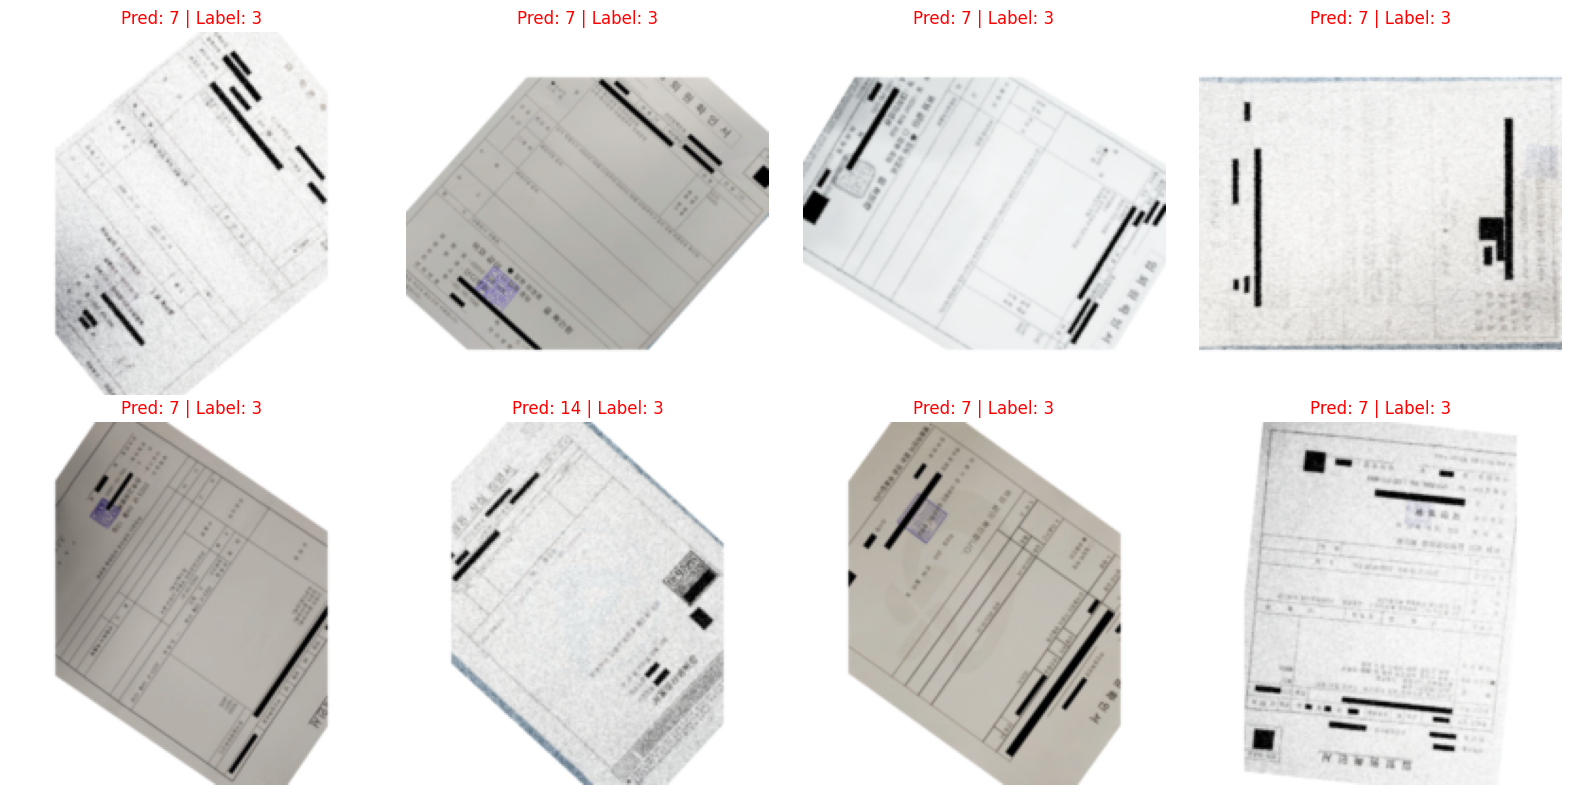

In [68]:
# 예시: DataFrame에서 8개만 시각화
df_subset = df_miss3.iloc[np.random.choice(len(df_miss3), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)


### label=7(medical_outpatient_certificate) 분석


In [18]:
df_miss7 = df_miss[df_miss['label'] == 7]

df_miss7['pred'].value_counts()


pred
3     70
14     7
4      5
13     3
12     1
Name: count, dtype: int64

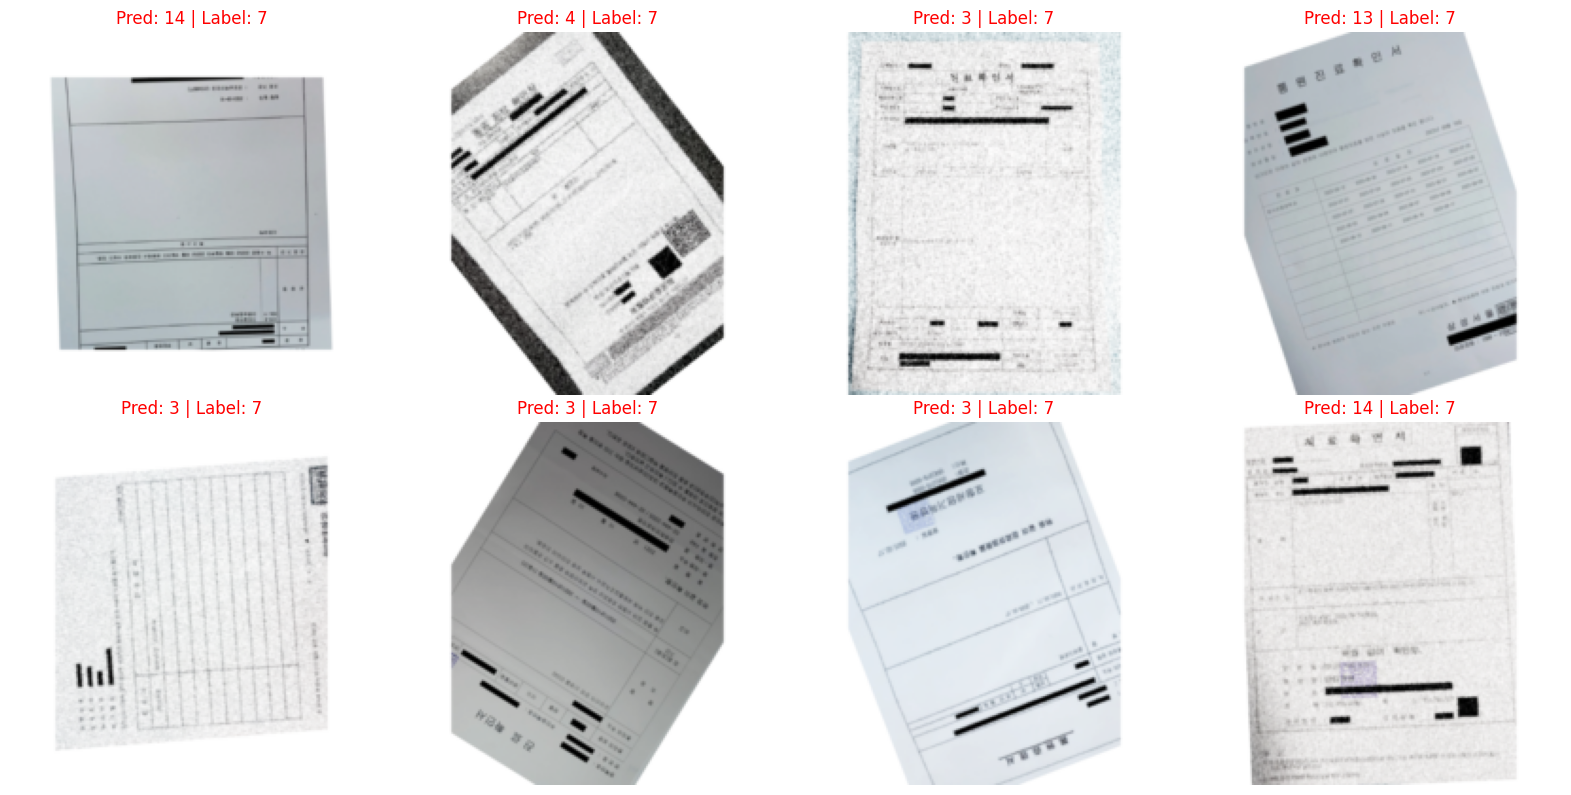

In [66]:
df_subset = df_miss7.iloc[np.random.choice(len(df_miss7), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)

### label = 14(statement_of_opinion) 분석


In [28]:
df_miss14 = df_miss[df_miss['label'] == 14]

df_miss14['pred'].value_counts()

pred
7     13
3     10
4      7
11     2
Name: count, dtype: int64

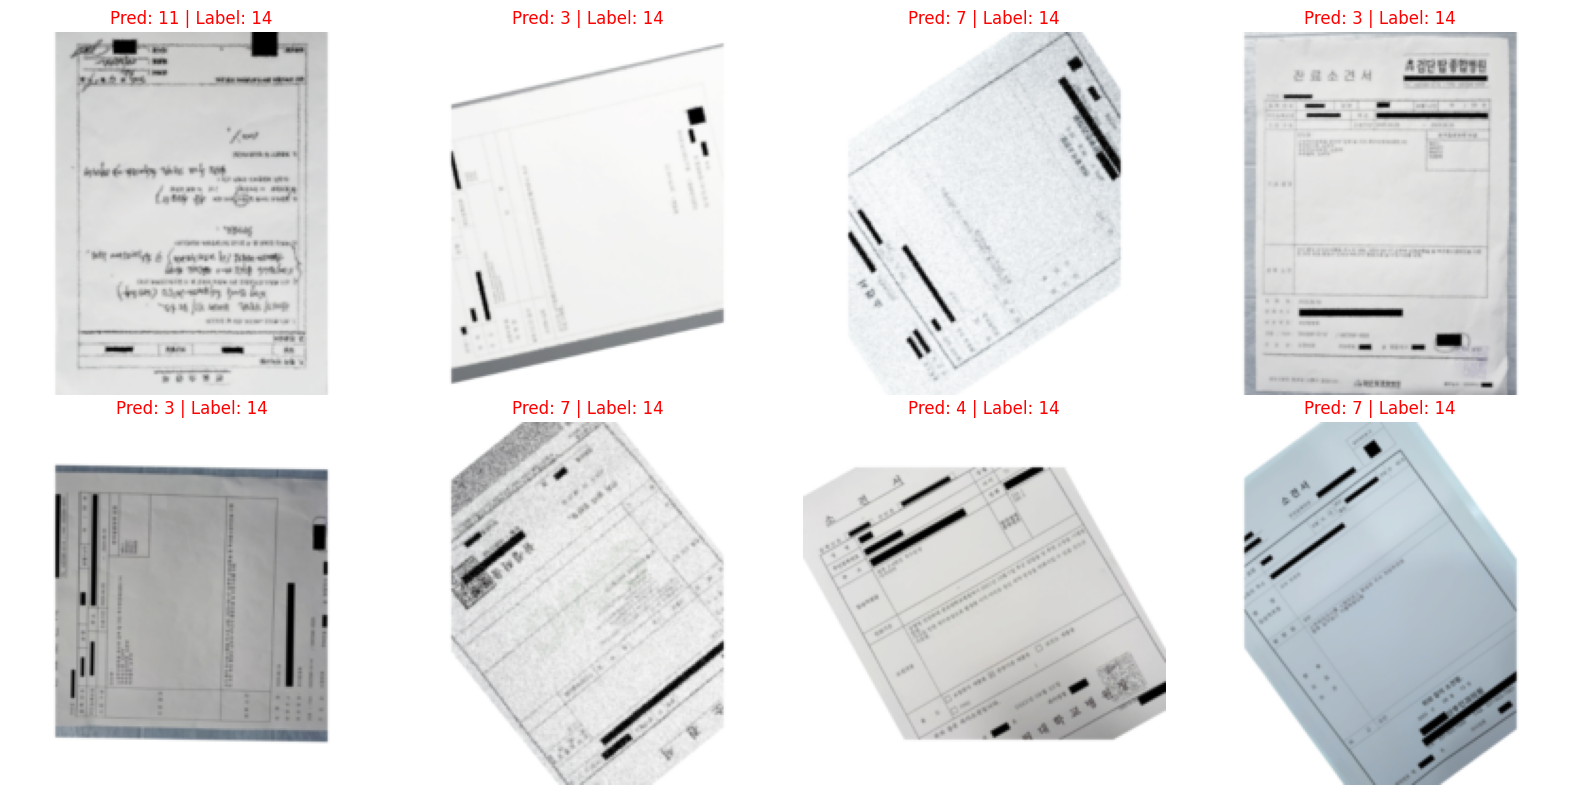

In [32]:
df_subset = df_miss14.iloc[np.random.choice(len(df_miss14), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)

### 맞춘 데이터 확인

In [33]:
df_correct = df[df['pred'] == df['label']]

df_correct['pred'].value_counts()

pred
5     200
9     200
2     200
15    200
0     200
16    200
8     199
6     199
12    196
11    190
10    185
4     171
13    140
3     125
7     114
1      89
14     68
Name: count, dtype: int64

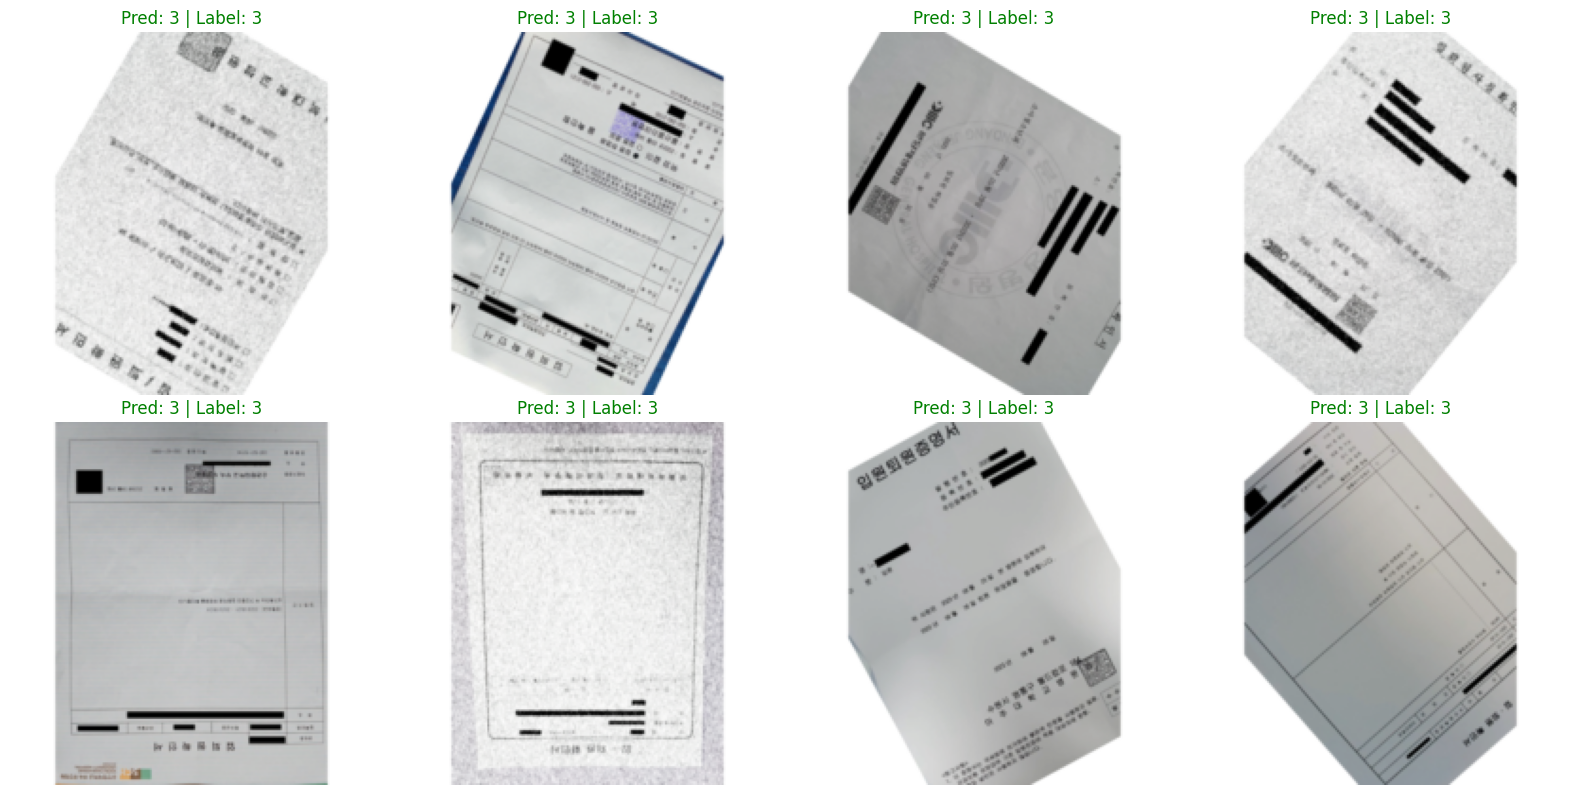

In [74]:
df_correct3 = df_correct[df_correct['label'] == 3]

df_subset = df_correct3.iloc[np.random.choice(len(df_correct3), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)